In [134]:
import tensorflow as tf
from keras.datasets import cifar100
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Activation, Lambda, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow import keras
import numpy as np
from tensorflow.keras.utils import plot_model
import datetime, os
import time
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications import VGG19

%load_ext tensorboard

In [1]:
from deakin.edu.au.data import Cifar100
import deakin.edu.au.models as models
import deakin.edu.au.metrics as metrics
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from graphviz import Digraph
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle


2021-07-19 03:08:51.462329: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-19 03:08:52.653005: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-19 03:08:52.726886: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-07-19 03:08:52.726927: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-19 03:08:52.730185: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-19 03:08:52.730275: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas

In [2]:
#Load dataset
dataset = Cifar100()
num_classes = [dataset.num_classes_l0, dataset.num_classes_l1, dataset.num_classes_l2]
u = dataset.draw_taxonomy()
# u.view()


In [3]:
batch = 128
epochs = 50
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
performance_callback = models.performance_callback(dataset.X_val, dataset.y_val, dataset.taxonomy)


In [ ]:
# Create the model
MLPH_model = models.get_MLPH_model(num_classes, dataset.image_size)
MLPH_model.summary()
#train model
history_MLPH_model = MLPH_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(MLPH_model)


Model: "MLPH_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten (Flatten)               (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_level_0 (Dense)             (None, 2)            1026        flatten[0][0]                    
_________________________________________________________________________________________

2021-07-19 03:08:56.197222: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-19 03:08:56.217012: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz


Epoch 1/50


2021-07-19 03:08:57.153664: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-07-19 03:08:57.606580: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2021-07-19 03:08:58.158670: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-19 03:08:58.551282: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


391/391 [==============================] - 17s 36ms/step - loss: 3.1115 - out_level_0_loss: 0.6343 - out_level_1_loss: 3.3859 - out_level_2_loss: 5.3143 - out_level_0_accuracy: 0.7430 - out_level_1_accuracy: 0.1288 - out_level_2_accuracy: 0.0144 - val_loss: 2.5351 - val_out_level_0_loss: 0.4285 - val_out_level_1_loss: 2.6233 - val_out_level_2_loss: 4.5537 - val_out_level_0_accuracy: 0.8140 - val_out_level_1_accuracy: 0.2232 - val_out_level_2_accuracy: 0.0174
----------------------------------------------------------------------------------------------------
epoch=1, Exact Match = 0.0054, accuracy level_0 = 0.8140, accuracy level_1 = 0.2232, accuracy level_2 = 0.0174, Consistency = 0.1028
----------------------------------------------------------------------------------------------------

Epoch 2/50
391/391 [==============================] - 13s 33ms/step - loss: 2.3708 - out_level_0_loss: 0.3626 - out_level_1_loss: 2.3824 - out_level_2_loss: 4.3673 - out_level_0_accuracy: 0.8454 - out_

In [ ]:
plt.figure(figsize=(15,4))
ax1 = plt.subplot(1, 2, 1)
for l in history_MLPH_model.history:
    if l == 'loss' or l == 'val_loss':  
        loss = history_MLPH_model.history[l]
        plt.plot(range(1, len(loss) + 1), loss, label=l)
        
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
for k in history_MLPH_model.history:
    if 'accuracy' in k:  
        loss = history_MLPH_model.history[k]
        plt.plot(range(1, len(loss) + 1), loss, label=k)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Create the model
BCNN1_model = models.get_BCNN1(num_classes, dataset.image_size)
BCNN1_model.summary()
#train model
history_BCNN1_model = BCNN1_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(BCNN1_model)


In [ ]:
def get_BCNN1(num_classes: list, image_size, reverse=False, conv_base=VGG19(include_top=False, weights="imagenet"),
              learning_rate=1e-5, loss_weights=[]):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = conv_base(in_layer)
    conv_base = Flatten()(conv_base)
    # create output layers
    out_layers = []
    if reverse:
        num_classes = list(reversed(num_classes))
    for idx, v in enumerate(num_classes):
        if reverse:
            idx = len(num_classes) - idx - 1
        if len(out_layers) == 0:
            out_layers.append(Dense(v, activation="softmax", name='out_level_' + str(idx))(conv_base))
        else:
            out_layers.append(Dense(v, activation="softmax", name='out_level_' + str(idx))(out_layers[-1]))
    if reverse:
        out_layers = list(reversed(out_layers))
    # Build the model
    model = Model(name='Model_BCNN1_reversed_' + str(reverse),
                  inputs=in_layer,
                  outputs=out_layers)
    loss = [keras.losses.SparseCategoricalCrossentropy() for x in num_classes]
    if len(loss_weights) == 0:
        loss_weights = [1 / len(num_classes) for x in num_classes]
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  loss_weights=loss_weights,
                  metrics=['accuracy'])
    return model


In [ ]:
# Create the model
BCNN1_reversed_model = get_BCNN1(num_classes, dataset.image_size, reverse=True)
BCNN1_reversed_model.summary()
#train model
history_BCNN1_reversed_model = BCNN1_reversed_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(BCNN1_reversed_model)

In [ ]:
# Create the model
BCNN2_model = models.get_BCNN2(num_classes, dataset.image_size)
BCNN2_model.summary()
#train model
history_BCNN2_model = BCNN2_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(BCNN2_model)

In [ ]:
# Create the model
BCNN2_reversed_model = models.get_BCNN2(num_classes, dataset.image_size, reverse=True)
BCNN2_reversed_model.summary()
#train model
history_BCNN2_reversed_model = BCNN2_reversed_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(BCNN2_reversed_model)


In [ ]:
# Create the model
mnets_model = models.get_mnets(num_classes, dataset.image_size, reverse=True)
mnets_model.summary()
#train model
history_mnets_model = mnets_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(mnets_model)


In [22]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Activation, Lambda, Conv2D, MaxPool2D, \
    GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow import keras

def get_Baseline_model(num_classes: list, image_size, conv_base=VGG19(include_top=False, weights="imagenet"),
                   learning_rate=1e-5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = conv_base(in_layer)
    conv_base = Flatten()(conv_base)
    # create output layers
    out_layer = Dense(num_classes[-1], activation="softmax", name='output')(conv_base)
    # Build the model
    model = Model(name='MLPH_model',
                  inputs=in_layer,
                  outputs=out_layer)
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    return model



Model: "MLPH_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_14 (Flatten)         (None, 512)               0         
_________________________________________________________________
output (Dense)               (None, 100)               51300     
Total params: 20,075,684
Trainable params: 20,075,684
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 13s 32ms/step - loss: 4.4065 - accuracy: 0.0494 - val_loss: 4.1612 - val_accuracy: 0.1130
Epoch 2/50
391/391 [==============================] - 12s 32ms/step - loss: 3.7871 - accuracy: 0.1

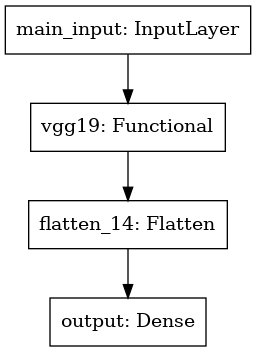

In [25]:
# Create the model
baseline_model = get_Baseline_model(num_classes, dataset.image_size)
baseline_model.summary()
#train model
history_baseline_model = baseline_model.fit(dataset.X_train, 
                    dataset.y_train[-1],
                    validation_data = (dataset.X_val, dataset.y_val[-1]), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[early_stopping_callback]
                    )
plot_model(baseline_model)


In [ ]:
MLPH_pred = MLPH_model.predict(dataset.X_test)
MLPH_pred = models.get_pred_indexes(MLPH_pred)

BCNN1_pred = BCNN1_model.predict(dataset.X_test)
BCNN1_pred = models.get_pred_indexes(BCNN1_pred)

BCNN1_reversed_pred = BCNN1_reversed_model.predict(dataset.X_test)
BCNN1_reversed_pred = models.get_pred_indexes(BCNN1_reversed_pred)

BCNN2_pred = BCNN2_model.predict(dataset.X_test)
BCNN2_pred = models.get_pred_indexes(BCNN2_pred)

BCNN2_reversed_pred = BCNN2_reversed_model.predict(dataset.X_test)
BCNN2_reversed_pred = models.get_pred_indexes(BCNN2_reversed_pred)

mnets_model_pred = mnets_model.predict(dataset.X_test)
mnets_model_pred = models.get_pred_indexes(mnets_model_pred)


In [ ]:
x1 = [metrics.get_exact_match(MLPH_pred, dataset.y_test),
     metrics.get_exact_match(BCNN1_pred, dataset.y_test),
     metrics.get_exact_match(BCNN1_reversed_pred, dataset.y_test),
     metrics.get_exact_match(BCNN2_pred, dataset.y_test),
     metrics.get_exact_match(BCNN2_reversed_pred, dataset.y_test),
     metrics.get_exact_match(mnets_model_pred, dataset.y_test)]

x2 = [metrics.get_h_accuracy(MLPH_pred, dataset.y_test),
     metrics.get_h_accuracy(BCNN1_pred, dataset.y_test),
     metrics.get_h_accuracy(BCNN1_reversed_pred, dataset.y_test),
     metrics.get_h_accuracy(BCNN2_pred, dataset.y_test),
     metrics.get_h_accuracy(BCNN2_reversed_pred, dataset.y_test),
     metrics.get_h_accuracy(mnets_model_pred, dataset.y_test)]


y = [metrics.get_consistency(MLPH_pred, dataset.taxonomy),
     metrics.get_consistency(BCNN1_pred, dataset.taxonomy),
     metrics.get_consistency(BCNN1_reversed_pred, dataset.taxonomy),
     metrics.get_consistency(BCNN2_pred, dataset.taxonomy),
     metrics.get_consistency(BCNN2_reversed_pred, dataset.taxonomy),
     metrics.get_consistency(mnets_model_pred, dataset.taxonomy)]



# Create example dataframe
df = pd.DataFrame({
'exact_match': x1,
'h_accuracy': x2,
'consistency': y,
's': [3000,3000,3000,3000,3000,3000],
'algo': ['MLPH','BCNN1','BCNN1_R','BCNN2','BCNN2_R', 'mnets']
})


In [ ]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.exact_match, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])



ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Exact Match')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
     ax.text(df.exact_match[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')


currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))


        
plt.savefig('plots/bubble_plot.pdf', bbox_inches = 'tight')
plt.show()


/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


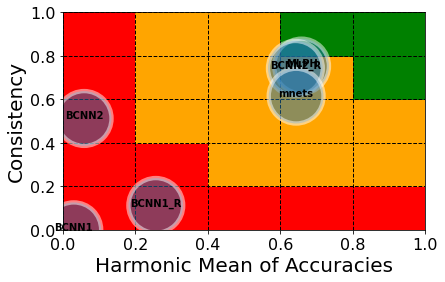

In [72]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.h_accuracy, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")



ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Harmonic Mean of Accuracies')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
     ax.text(df.h_accuracy[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')

        

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))


In [ ]:
class Custom_Layer(keras.layers.Layer):
    def __init__(self, M, mode='both'):
        super(Custom_Layer, self).__init__()
        self.M = M
        if mode in ['both', 'c_to_f', 'f_to_c']:
          self.mode = mode

    def build(self, input_shape):
        """Creates scale variable if use_scale==True."""
        if isinstance(input_shape, list):
          input_dim1 = input_shape[0][1]
          input_dim2 = input_shape[0][1]
        else:
          input_dim1 = input_shape[1]
          input_dim2 = input_shape[1]
        
        units_c = len(self.M)
        units_f = len(self.M[0])
        self.M = tf.convert_to_tensor(self.M, dtype=tf.float32)

        self.W_c = self.add_weight(
            shape=(input_dim1, units_c), initializer="random_normal", trainable=True
        )
        self.b_c = self.add_weight(shape=(units_c,), initializer="zeros", trainable=True)
        self.W_f = self.add_weight(
            shape=(input_dim2, units_f), initializer="random_normal", trainable=True
        )
        self.b_f = self.add_weight(shape=(units_f,), initializer="zeros", trainable=True)

    def call(self, inputs):
      # Code the six equation
      if isinstance(inputs, list):
        inputs1 = inputs[0]
        inputs2 = inputs[1]
      else:
        inputs1 = inputs
        inputs2 = inputs
      
      z_c = tf.matmul(inputs1, self.W_c) + self.b_c # z^{(i)}_{c}= a^{[l]} \times W_{c} + b_{c}
      z_f = tf.matmul(inputs2, self.W_f) + self.b_f #  z^{(i)}_{f}= a^{[l]} \times  W_{f}+ b_{f}
      if self.mode == 'both' or self.mode == 'f_to_c':
        m_c = tf.matmul(tf.nn.softmax(z_f), tf.transpose(self.M)) # m^{(i)}_{c}= softmax(z^{(i)}_{f})\times M^{T}            
        y_c = tf.nn.softmax(z_c * m_c) # \hat{y}^{(i)}_{c}= softmax(z^{(i)}_{c}\circ m^{(i)}_{c})
      else:
        y_c = tf.nn.softmax(z_c)

      if self.mode == 'both' or self.mode == 'c_to_f':
        m_f = tf.matmul(tf.nn.softmax(z_c), self.M) #  m^{(i)}_{f}= softmax(z^{(i)}_{c})\times M
        y_f = tf.nn.softmax(z_f * m_f) # \hat{y}^{(i)}_{f}= softmax(z^{(i)}_{f}\circ m^{(i)}_{f})
      else:
        y_f = tf.nn.softmax(z_f)

      return y_c, y_f

    def get_config(self):
        config = {'M': self.M, 
                  'W_c': self.W_c,
                  'W_f': self.W_f,
                  'b_f': self.b_f,
                  'b_f': self.b_f}
        base_config = super(Custom_Layer, self).get_config()
        return base_config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
def get_model7(learning_rate=1e-5, pi=0.5, mode='both'):
    # Conv base
    in_layer = Input(shape=dataset.image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # outputs 
    out_c, out_f = Custom_Layer(M, mode)(conv_base)
    # Build the model
    model = Model(name='Model_7',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

model = get_model7()
model.summary()
plot_model(model)


In [ ]:
def get_model8(learning_rate=1e-5, pi=0.5, mode='both'):
    # Conv base
    conv_base1 = keras.applications.VGG19(
    include_top=False,
    weights="imagenet")
    conv_base1._name = 'vgg19_1'
    conv_base2 = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")
    conv_base2._name = 'vgg19_2'
    in_layer = Input(shape=image_size, name='main_input')
    conv_base1 = conv_base1(in_layer)    
    conv_base1 = Flatten()(conv_base1)

    conv_base2 = conv_base2(in_layer)
    conv_base2 = Flatten()(conv_base2)

    out_c, out_f = Custom_Layer(M, mode)([conv_base1, conv_base2])
    # Build the model
    model = Model(name='Model_8',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model8()
# model.summary()
# plot_model(model)

In [ ]:
data = pd.DataFrame(columns=['algo','accuracy'])
data_list = list(zip(['Coarse-grained\n classifier']*len(accuracy_c), accuracy_c))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy']),ignore_index=True)

data_list = list(zip(['Fine-grained\n classifier']*len(accuracy_f), accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy']),ignore_index=True)

plt.figure(figsize=(5.5, 3.8))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)

ax = sns.barplot(x="algo", y="accuracy", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("% correct predictions")
# plt.title("Box plot of #candidates per cycle and system")

plt.ylim(0, 100)
plt.xticks(rotation=0)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
data = pd.DataFrame(columns=['algo','consistency'])

data_list = list(zip(['XXX']*len(consistency), consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','consistency']),ignore_index=True)

plt.figure(figsize=(2, 3.8))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
ax = sns.barplot(x="algo", y="consistency", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("% inconsistent preds")
# plt.title("Box plot of #candidates per cycle and system")

plt.ylim(0, 100)
plt.xticks(rotation=0)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
data = pd.DataFrame(columns=['algo','consistency2'])

data_list = list(zip(['XXX']*len(consistency2), consistency2))
data = data.append(pd.DataFrame(data_list, columns=['algo','consistency2']),ignore_index=True)

plt.figure(figsize=(2, 3.8))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
ax = sns.barplot(x="algo", y="consistency2", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("% inconsistent preds")
# plt.title("Box plot of #candidates per cycle and system")
plt.ylim(0, 100)
plt.xticks(rotation=0)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
data = pd.DataFrame(columns=['algo','consistency3'])

data_list = list(zip(['XXX']*len(consistency3), consistency3))
data = data.append(pd.DataFrame(data_list, columns=['algo','consistency3']),ignore_index=True)

plt.figure(figsize=(2, 3.8))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
ax = sns.barplot(x="algo", y="consistency3", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("% inconsistent preds")
# plt.title("Box plot of #candidates per cycle and system")
plt.ylim(0, 100)
plt.xticks(rotation=0)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
data = pd.DataFrame(columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency'])

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model1_pi1, X_test, y_test)
# data_list = list(zip(['model1_pi1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model1_pi0, X_test, y_test)
# data_list = list(zip(['model1_pi0']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model1_pi0_5, X_test, y_test)
data_list = list(zip(['model1_pi0.5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model2, X_test, y_test)
# data_list = list(zip(['model2']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model3, X_test, y_test)
# data_list = list(zip(['model3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model4, X_test, y_test)
# data_list = list(zip(['model4']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model5, X_test, y_test)
data_list = list(zip(['model5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model6, X_test, y_test)
data_list = list(zip(['model6']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)


accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_1, X_test, y_test)
data_list = list(zip(['model7_pi_0_1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_3, X_test, y_test)
data_list = list(zip(['model7_pi_0_3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_5, X_test, y_test)
data_list = list(zip(['model7_pi_0_5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_7, X_test, y_test)
data_list = list(zip(['model7_pi_0_7']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_9, X_test, y_test)
data_list = list(zip(['model7_pi_0_9']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_1, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_3, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_5, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_7, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_7']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_9, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_9']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_1, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_3, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_5, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_7, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_7']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_9, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_9']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)





accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model8, X_test, y_test)
data_list = list(zip(['model8']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model8_c_to_f, X_test, y_test)
data_list = list(zip(['model8_c_to_f']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model8_f_to_c, X_test, y_test)
data_list = list(zip(['model8_f_to_c']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)


In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.3, 0.52)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy_c", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy_c")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.7, 0.85)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy_f", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy_f")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.4, 0.55)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy_consistency", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("accuracy_consistency")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.65, 0.85)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="consistency", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.7, 1.)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()


In [ ]:
plt.figure(figsize=(15,4))
ax1 = plt.subplot(1, 2, 1)
for l in history_MLPH_model.history:
    if l == 'loss' or l == 'val_loss':  
        loss = history_MLPH_model.history[l]
        plt.plot(range(1, len(loss) + 1), loss, label=l)
        
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
for k in history_MLPH_model.history:
    if 'accuracy' in k:  
        loss = history_MLPH_model.history[k]
        plt.plot(range(1, len(loss) + 1), loss, label=k)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def nin(input_shape):
    # Define Network in Network model
    input = Input(shape=input_shape)
    x = Conv2D(filters=192, kernel_size=(5,5), activation='relu')(input)
    x = Conv2D(filters=160, kernel_size=(1,1), activation='relu')(x)
    x = Conv2D(filters=96, kernel_size=(1,1), activation='relu')(x)
    x = MaxPool2D(2, strides=2, padding='same')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(filters=192, kernel_size=(5,5), activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=(1,1), activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=(1,1), activation='relu')(x)
    x = MaxPool2D(2, strides=2, padding='same')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(filters=192, kernel_size=(3,3), activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=(1,1), activation='relu')(x)
    x = Conv2D(filters=10, kernel_size=(1,1), activation='relu')(x)

    output = GlobalAveragePooling2D()(x)

    model = Model(input, output)

    return model 


    
model = nin(input_shape=(28,28,1))

model.summary()


In [ ]:
conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")
type(model)